# Paper statistics

## netCDF distribution by aggregation

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

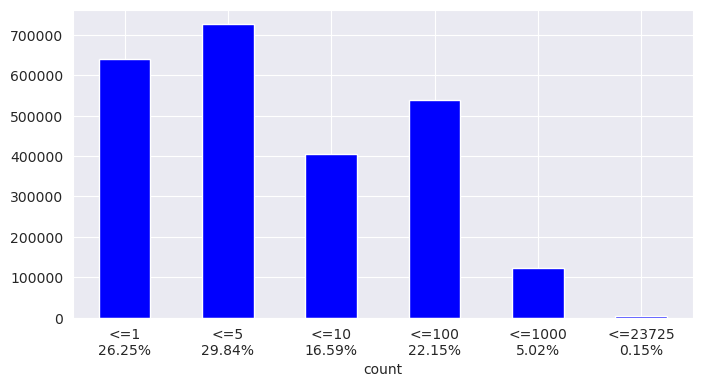

In [2]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1, figsize=(8, 4))

    with zipfile.ZipFile("ncml_dist.csv.zip", "r") as zip_file:
        df = pd.read_csv(zip_file.namelist()[0], names=["name", "count"], skiprows=1)

    bins = [0, 1, 5, 10, 100, 1000, df["count"].max()]
    cuts = pd.cut(df["count"], bins=bins).value_counts(sort=False)
    cuts.plot.bar(rot=0, color="b", ax=ax)
    ax.set_xticklabels(["<={}\n{}%".format(c.right, round(v/len(df)*100,2)) for c,v in zip(cuts.index.categories, cuts.values)])

## Chunking times

In [3]:
import netCDF4
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def test(dset):
    return dset[...].mean()

In [5]:
sizes = [256, 512, 1024, 2048, 4096, 8192]
results = []

for size in sizes:
    with netCDF4.Dataset("test.nc", "w") as f:
        f.createDimension("time", size)
        f.createVariable("time1", "f8", ("time",))
        f.createVariable("time2", "f8", ("time",), chunksizes=(1,))

        f["time1"][...] = list(range(size))
        f["time2"][...] = list(range(size))

    with netCDF4.Dataset("test.nc", "r") as f:
        results.append(timeit.timeit(lambda : test(f["time1"]), number=100))
        results.append(timeit.timeit(lambda : test(f["time2"]), number=100))

In [6]:
!ncdump -hs test.nc

netcdf test {
dimensions:
	time = 8192 ;
variables:
	double time1(time) ;
		time1:_Storage = "contiguous" ;
		time1:_Endianness = "little" ;
	double time2(time) ;
		time2:_Storage = "chunked" ;
		time2:_ChunkSizes = 1 ;
		time2:_Endianness = "little" ;

// global attributes:
		:_NCProperties = "version=2,netcdf=4.9.2,hdf5=1.14.2" ;
		:_SuperblockVersion = 2 ;
		:_IsNetcdf4 = 1 ;
		:_Format = "netCDF-4" ;
}


In [7]:
results

[0.017187107001518598,
 0.041888941999786766,
 0.014517129999148892,
 0.06677054299871088,
 0.014807597999606514,
 0.14525874700120767,
 0.015400944001157768,
 0.370491863002826,
 0.015241618002619362,
 0.9814411840015964,
 0.015440570001373999,
 2.5705285069998354]

Text(0.5, 1.0, 'Load time for sizes [256, 512, 1024, 2048, 4096, 8192]')

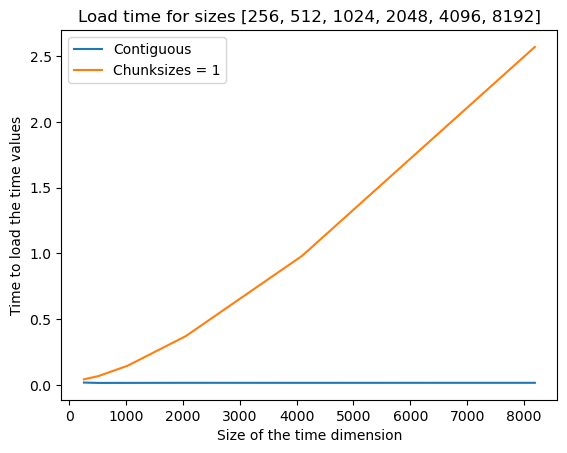

In [8]:
plt.plot(sizes, results[0::2], label="Contiguous")
plt.plot(sizes, results[1::2], label="Chunksizes = 1")
plt.legend()
plt.xlabel("Size of the time dimension")
plt.ylabel("Time to load the time values")
plt.title("Load time for sizes [256, 512, 1024, 2048, 4096, 8192]")